In [ ]:

import numpy as np 
import pandas as pd 
import torch.optim
 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# define transformations for test
test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
#train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
#test_transform = transforms.Compose([transforms.ToTensor()])

# define training dataloader
def get_training_dataloader(train_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        train_transform: transfroms for train dataset
        path: path to cifar10 training python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: train_data_loader:torch dataloader object
    """

    transform_train = train_transform
    cifar10_training = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=transform_train)
    cifar10_training_loader = DataLoader(
        cifar10_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_training_loader

# define test dataloader
def get_testing_dataloader(test_transform, batch_size=128, num_workers=0, shuffle=True):
    """ return training dataloader
    Args:
        test_transform: transforms for test dataset
        path: path to cifar100 test python dataset
        batch_size: dataloader batchsize
        num_workers: dataloader num_works
        shuffle: whether to shuffle 
    Returns: cifar10_test_loader:torch dataloader object
    """

    transform_test = test_transform
    cifar10_test = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transform_test)
    cifar10_test_loader = DataLoader(cifar10_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)

    return cifar10_test_loader

In [ ]:
trainloader = get_training_dataloader(train_transform)
testloader = get_testing_dataloader(test_transform)

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
classes_dict = {0 : 'airplane', 1 : 'automobile', 2: 'bird', 3 : 'cat', 4 : 'deer', 5: 'dog', 6:'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution 
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and 
        #we refer to our network with such a bottleneck layer, i.e., 
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` , 
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
             )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments 
        #consist of a batch normalization layer and an 1×1 
        #convolutional layer followed by a 2×2 average pooling 
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.down_sample(x)

#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=10):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution 
        #with 16 (or twice the growth rate for DenseNet-BC) 
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each 
        #side of the inputs is zero-padded by one pixel to keep 
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False) 

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            #"""If a dense block contains m feature-maps, we let the 
            #following transition layer generate θm output feature-
            #maps, where 0 < θ ≤ 1 is referred to as the compression 
            #fac-tor.
            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('activation', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        output = self.conv1(x)
        output = self.features(output)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.linear(output)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121(activation = 'relu'):
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)



In [ ]:
epochs = 70
# learning rate
learning_rate = 0.001
# device to use
# don't forget to turn on GPU on kernel's settings
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = densenet121()

In [ ]:
# set loss function
criterion = nn.CrossEntropyLoss()

# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = torch.optim.Adam (model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD (model.parameters(), lr=learning_rate,momentum=.9,nesterov=True,weight_decay=1e-4)

In [ ]:
print("No of params in model is " , sum(p.numel() for p in model.parameters() if p.requires_grad))

No of params in model is  1000618


In [ ]:
train_stats = pd.DataFrame(columns = ['Epoch', 'Time per epoch', 'Avg time per step', 'Train loss', 'Train accuracy', 'Train top-3 accuracy','Test loss', 'Test accuracy', 'Test top-3 accuracy']) 

In [ ]:
import time
#train the model
model.to(device)

steps = 0
running_loss = 0
for epoch in range(epochs):
    
    since = time.time()
    
    train_accuracy = 0
    top3_train_accuracy = 0 
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # calculate train top-1 accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # Calculate train top-3 accuracy
        np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
        target_numpy = labels.cpu().numpy()
        top3_train_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])
        
    time_elapsed = time.time() - since
    
    test_loss = 0
    test_accuracy = 0
    top3_test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            test_loss += batch_loss.item()

            # Calculate test top-1 accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Calculate test top-3 accuracy
            np_top3_class = ps.topk(3, dim=1)[1].cpu().numpy()
            target_numpy = labels.cpu().numpy()
            top3_test_accuracy += np.mean([1 if target_numpy[i] in np_top3_class[i] else 0 for i in range(0, len(target_numpy))])

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Time per epoch: {time_elapsed:.4f}.. "
          f"Average time per step: {time_elapsed/len(trainloader):.4f}.. "
          f"Train loss: {running_loss/len(trainloader):.4f}.. "
          f"Train accuracy: {train_accuracy/len(trainloader):.4f}.. "
          f"Top-3 train accuracy: {top3_train_accuracy/len(trainloader):.4f}.. "
          f"Test loss: {test_loss/len(testloader):.4f}.. "
          f"Test accuracy: {test_accuracy/len(testloader):.4f}.. "
          f"Top-3 test accuracy: {top3_test_accuracy/len(testloader):.4f}")

    
    
    train_stats = train_stats.append({'Epoch': epoch, 'Time per epoch':time_elapsed, 'Avg time per step': time_elapsed/len(trainloader), 'Train loss' : running_loss/len(trainloader), 'Train accuracy': train_accuracy/len(trainloader), 'Train top-3 accuracy':top3_train_accuracy/len(trainloader),'Test loss' : test_loss/len(testloader), 'Test accuracy': test_accuracy/len(testloader), 'Test top-3 accuracy':top3_test_accuracy/len(testloader)}, ignore_index=True)

    running_loss = 0
    model.train()

Epoch 1/70.. Time per epoch: 72.7255.. Average time per step: 0.1860.. Train loss: 1.4236.. Train accuracy: 0.4762.. Top-3 train accuracy: 0.8019.. Test loss: 1.2941.. Test accuracy: 0.5382.. Top-3 test accuracy: 0.8610
Epoch 2/70.. Time per epoch: 73.4199.. Average time per step: 0.1878.. Train loss: 1.0545.. Train accuracy: 0.6215.. Top-3 train accuracy: 0.8901.. Test loss: 0.8919.. Test accuracy: 0.6819.. Top-3 test accuracy: 0.9228
Epoch 3/70.. Time per epoch: 72.8805.. Average time per step: 0.1864.. Train loss: 0.8947.. Train accuracy: 0.6814.. Top-3 train accuracy: 0.9176.. Test loss: 0.7728.. Test accuracy: 0.7270.. Top-3 test accuracy: 0.9367
Epoch 4/70.. Time per epoch: 73.1540.. Average time per step: 0.1871.. Train loss: 0.7928.. Train accuracy: 0.7187.. Top-3 train accuracy: 0.9319.. Test loss: 0.7249.. Test accuracy: 0.7476.. Top-3 test accuracy: 0.9463
Epoch 5/70.. Time per epoch: 72.5095.. Average time per step: 0.1854.. Train loss: 0.7031.. Train accuracy: 0.7551.. Top

Epoch 39/70.. Time per epoch: 73.0668.. Average time per step: 0.1869.. Train loss: 0.1467.. Train accuracy: 0.9479.. Top-3 train accuracy: 0.9962.. Test loss: 0.3730.. Test accuracy: 0.8923.. Top-3 test accuracy: 0.9838
Epoch 40/70.. Time per epoch: 72.0848.. Average time per step: 0.1844.. Train loss: 0.1410.. Train accuracy: 0.9502.. Top-3 train accuracy: 0.9969.. Test loss: 0.3947.. Test accuracy: 0.8863.. Top-3 test accuracy: 0.9833
Epoch 41/70.. Time per epoch: 72.3143.. Average time per step: 0.1849.. Train loss: 0.1403.. Train accuracy: 0.9499.. Top-3 train accuracy: 0.9965.. Test loss: 0.3759.. Test accuracy: 0.8936.. Top-3 test accuracy: 0.9856
Epoch 42/70.. Time per epoch: 72.3444.. Average time per step: 0.1850.. Train loss: 0.1318.. Train accuracy: 0.9527.. Top-3 train accuracy: 0.9972.. Test loss: 0.4065.. Test accuracy: 0.8855.. Top-3 test accuracy: 0.9832
Epoch 43/70.. Time per epoch: 72.1485.. Average time per step: 0.1845.. Train loss: 0.1360.. Train accuracy: 0.9524.

In [ ]:
#train_stats.to_csv('train_log_DenseNet121.csv')
from IPython.display import FileLink
FileLink(r'train_log_DenseNet121.csv')

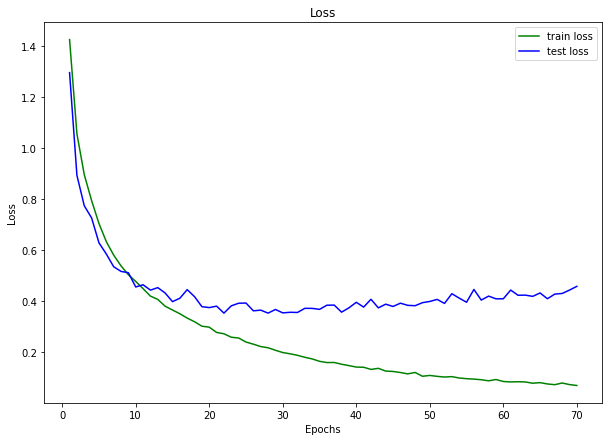

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss");

x = range(1, len(train_stats['Train loss'].values) + 1)
ax.plot(x, train_stats['Train loss'].values, '-g', label='train loss');
ax.plot(x, train_stats['Test loss'].values, '-b', label='test loss');

plt.legend() 

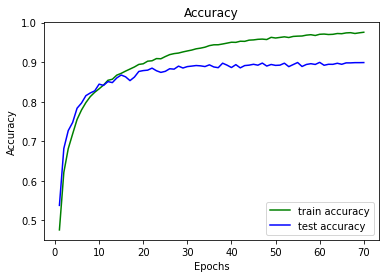

In [ ]:
ax = plt.axes()

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

x = range(1, len(train_stats['Train accuracy'].values) + 1)
ax.plot(x, train_stats['Train accuracy'].values, '-g', label='train accuracy');
ax.plot(x, train_stats['Test accuracy'].values, '-b', label='test accuracy');

plt.legend()

In [ ]:
md ='save_model_1.pt'
torch.save(model.state_dict(),md)

In [ ]:
from IPython.display import FileLink
FileLink(r'save_model_1.pt')

In [ ]:
model.load_state_dict(torch.load('/content/save_model_1 (1).pt',map_location=torch.device('cpu')))
model.eval()

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (features): Sequential(
    (dense_block_layer_0): Sequential(
      (bottle_neck_layer_0): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
          (5): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (bottle_neck_layer_1): Bottleneck(
        (bottle_neck): Sequential(
          (0): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(48, ep

In [ ]:
def view_classify(img, ps, title):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
        title - (str) string with true label
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    image = img.permute(1, 2, 0)
    ax1.imshow(image.numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(classes_dict.values()), size='small');
    ax2.set_title(title)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


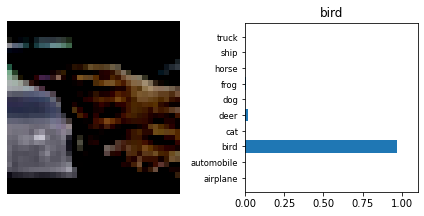

In [ ]:
for batch_idx, (inputs, labels) in enumerate(testloader):
    inputs, labels = inputs.to(device), labels.to(device)
    img = inputs[0]
    label_true = labels[0]
    ps = model(inputs)
    view_classify(img.cpu(), torch.softmax(ps[0].cpu(), dim=0), classes_dict[int(label_true.cpu().numpy())])
    
    break;

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [ ]:
cifar10_training = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)

Files already downloaded and verified


In [ ]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(cifar10_training, batch_size=10000)
    train_preds = get_all_preds(model, prediction_loader)

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
 preds_correct = get_num_correct(train_preds, train_set.targets)
 print('total correct:', preds_correct)
 print('accuracy:', preds_correct / len(train_set))